In [137]:
!pip install tqdm
!pip install catboost

In [138]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.callbacks import CallbackAny2Vec
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

#Dataset

In [139]:
unbalanced_dataset = pd.read_csv("result.csv")
unbalanced_dataset["label"] = unbalanced_dataset.label.astype("int64")

In [140]:
dataset_label = {
  0:"cobaltstrike",
  1:"bruteratel",
  2:"covenant",
  3:"deimos",
  4:"sliver",
  5:"posh",
  6:"metsploit"
}

Plotting unbalanced dataset

{0: 120, 1: 53, 2: 11, 3: 19, 4: 43, 5: 14, 6: 174}


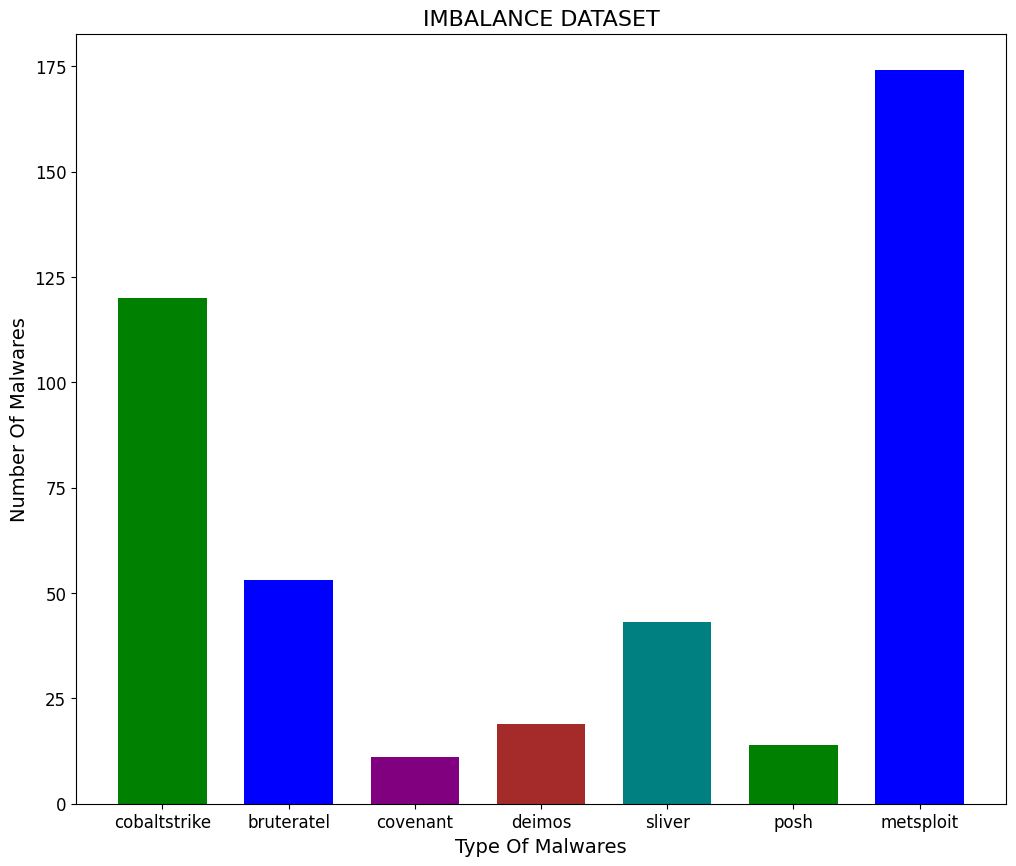

In [141]:
unbalanced_dataset_size = unbalanced_dataset["label"].value_counts().to_dict()
unbalanced_dataset_size = {k: v for k, v in sorted(list(unbalanced_dataset_size.items()))}
print(unbalanced_dataset_size)

names = list(dataset_label.values())
values = list(unbalanced_dataset_size.values())
New_Colors = ["green","blue","purple","brown","teal"]
plt.figure(figsize=(12,10))
plt.bar(names,values,color=New_Colors,width=0.7)
plt.xticks(fontsize= 12 )
plt.yticks(fontsize= 12)
plt.title("IMBALANCE DATASET",fontsize=16)
plt.xlabel("Type Of Malwares", fontsize=14)
plt.ylabel("Number Of Malwares", fontsize=14)
plt.show()

#Word Embedding

In [142]:
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print(f"Epoch {self.epoch}")
        self.epoch += 1

epoch_logger = EpochLogger()

In [143]:
def api_sequence_to_vector(api_sequence, model):
    vector = []
    for api in api_sequence:
        if api in model.wv:
            vector.append(model.wv[api])
        else:
            vector.append([0] * 256)
    return vector

In [144]:
unbalanced_dataset["data"] = unbalanced_dataset["data"].str.split()
unbalanced_dataset

,data,node,edge,label
0,"[Adobe_XMP_Identifier, SizeofResource, WritePr...",411,426,1
1,"[T1129, T1569.002, ChangeServiceConfig2A, Chan...",0,0,1
2,"[T1213, T1056.001, T1222, T1562.004, T1112, T1...",0,0,1
3,"[brc4_shellcode, HKTL_BruteRatel_Badger_Indica...",0,0,1
4,"[ExitProcess, HeapSize, UnhandledExceptionFilt...",0,0,1
...,...,...,...,...
429,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4
430,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4
431,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4
432,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4


In [145]:
model = Word2Vec(unbalanced_dataset["data"], vector_size=256, window=5, min_count=1, sg=0, callbacks=[epoch_logger])
model.save("word2vec.model")

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [146]:
unbalanced_dataset["data_vector"] = unbalanced_dataset["data"].apply(lambda x: api_sequence_to_vector(x, model))
unbalanced_dataset["data_vector_mean"] = unbalanced_dataset["data_vector"].apply(lambda x: np.mean(x))
unbalanced_dataset["data_vector_std"] = unbalanced_dataset["data_vector"].apply(lambda x: np.std(x))
unbalanced_dataset

,data,node,edge,label,data_vector,data_vector_mean,data_vector_std
0,"[Adobe_XMP_Identifier, SizeofResource, WritePr...",411,426,1,"[[0.0029508842, -0.0038631938, 0.0012454907, 0...",-0.000167,0.268125
1,"[T1129, T1569.002, ChangeServiceConfig2A, Chan...",0,0,1,"[[0.11741886, -0.13788714, -0.0008808619, 0.26...",-0.005485,0.328464
2,"[T1213, T1056.001, T1222, T1562.004, T1112, T1...",0,0,1,"[[0.00547874, -0.0066895965, 0.0023528899, 0.0...",-0.000803,0.191597
3,"[brc4_shellcode, HKTL_BruteRatel_Badger_Indica...",0,0,1,"[[0.043382794, -0.045163464, 0.0030022261, 0.0...",-0.000798,0.194077
4,"[ExitProcess, HeapSize, UnhandledExceptionFilt...",0,0,1,"[[0.25458178, -0.29230347, 0.13271326, 0.79615...",-0.000802,0.194684
...,...,...,...,...,...,...,...
429,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4,"[[0.06243829, -0.21511275, -0.17712489, 0.3994...",0.000415,0.320266
430,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4,"[[0.06243829, -0.21511275, -0.17712489, 0.3994...",0.000415,0.320266
431,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4,"[[0.06243829, -0.21511275, -0.17712489, 0.3994...",0.000415,0.320266
432,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4,"[[0.06243829, -0.21511275, -0.17712489, 0.3994...",0.000415,0.320266


In [147]:
unbalanced_dataset = unbalanced_dataset.drop(columns=["data", "data_vector"])
unbalanced_dataset

,node,edge,label,data_vector_mean,data_vector_std
0,411,426,1,-0.000167,0.268125
1,0,0,1,-0.005485,0.328464
2,0,0,1,-0.000803,0.191597
3,0,0,1,-0.000798,0.194077
4,0,0,1,-0.000802,0.194684
...,...,...,...,...,...
429,0,0,4,0.000415,0.320266
430,0,0,4,0.000415,0.320266
431,0,0,4,0.000415,0.320266
432,0,0,4,0.000415,0.320266


#Imputation

In [148]:
imputer = SimpleImputer(strategy="mean")
unbalanced_dataset = pd.DataFrame(imputer.fit_transform(unbalanced_dataset), columns=unbalanced_dataset.columns)

#Data Balancing

In [149]:
df_cobaltstrike_0 = unbalanced_dataset[unbalanced_dataset.label == 0][:]
df_bruteratel_1 = unbalanced_dataset[unbalanced_dataset.label == 1][:]
df_covenant_2 = unbalanced_dataset[unbalanced_dataset.label == 2][:]
df_deimos_3 = unbalanced_dataset[unbalanced_dataset.label == 3][:]
df_sliver_4 = unbalanced_dataset[unbalanced_dataset.label == 4][:]
df_posh_5 = unbalanced_dataset[unbalanced_dataset.label == 5][:]
df_metasploit_6 = unbalanced_dataset[unbalanced_dataset.label == 6][:]

Downsampling

In [150]:
def resample_df(df, number_samples):
    from sklearn.utils import resample
    return resample(df, n_samples=number_samples, replace=False, random_state=0)

In [151]:
df_cobaltstrike_resampled = resample_df(df_cobaltstrike_0, 50)
df_bruteratel_resampled = resample_df(df_bruteratel_1, 50)
df_metasploit_resampled = resample_df(df_metasploit_6, 50)

df_cobaltstrike_resampled.reset_index(drop=True, inplace=True)
df_bruteratel_resampled.reset_index(drop=True, inplace=True)
df_metasploit_resampled.reset_index(drop=True, inplace=True)

balanced_dataset = pd.concat([
    df_cobaltstrike_resampled,
    df_bruteratel_resampled,
    df_metasploit_resampled
])

balanced_dataset

,node,edge,label,data_vector_mean,data_vector_std
0,0.0,0.0,0.0,-0.004128,0.364244
1,0.0,0.0,0.0,0.000005,0.226668
2,0.0,0.0,0.0,-0.004207,0.350514
3,0.0,0.0,0.0,0.006658,0.324138
4,0.0,0.0,0.0,-0.004638,0.359297
...,...,...,...,...,...
45,0.0,0.0,6.0,-0.000475,0.050862
46,0.0,0.0,6.0,-0.001421,0.191190
47,4170.0,5713.0,6.0,-0.004856,0.312244
48,0.0,0.0,6.0,-0.001421,0.191190


Upsampling

In [152]:
balanced_dataset = pd.concat([balanced_dataset, df_covenant_2])

In [153]:
X = balanced_dataset.drop(["label"], axis=1)
y = balanced_dataset["label"]

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

balanced_dataset = X_res[:]
balanced_dataset["label"] = y_res

balanced_dataset.shape

(200, 5)

In [154]:
balanced_dataset = pd.concat([balanced_dataset, df_deimos_3])

In [155]:
X = balanced_dataset.drop(["label"], axis=1)
y = balanced_dataset["label"]

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

balanced_dataset = X_res[:]
balanced_dataset["label"] = y_res

balanced_dataset.shape

(250, 5)

In [156]:
balanced_dataset = pd.concat([balanced_dataset, df_sliver_4])

In [157]:
X = balanced_dataset.drop(["label"], axis=1)
y = balanced_dataset["label"]

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

balanced_dataset = X_res[:]
balanced_dataset["label"] = y_res

balanced_dataset.shape

(300, 5)

In [158]:
balanced_dataset = pd.concat([balanced_dataset, df_posh_5])

In [159]:
X = balanced_dataset.drop(["label"], axis=1)
y = balanced_dataset["label"]

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

balanced_dataset = X_res[:]
balanced_dataset["label"] = y_res

balanced_dataset.shape

(350, 5)

In [160]:
balanced_dataset["node"] = balanced_dataset["node"].astype(int)
balanced_dataset["edge"] = balanced_dataset["edge"].astype(int)
balanced_dataset["label"] = balanced_dataset["label"].astype(int)
balanced_dataset

,node,edge,data_vector_mean,data_vector_std,label
0,0,0,-0.004128,0.364244,0
1,0,0,0.000005,0.226668,0
2,0,0,-0.004207,0.350514,0
3,0,0,0.006658,0.324138,0
4,0,0,-0.004638,0.359297,0
...,...,...,...,...,...
345,0,0,-0.005422,0.316034,5
346,0,0,-0.005586,0.320928,5
347,0,0,-0.005631,0.322253,5
348,0,0,-0.005631,0.322253,5


Plotting balanced dataset

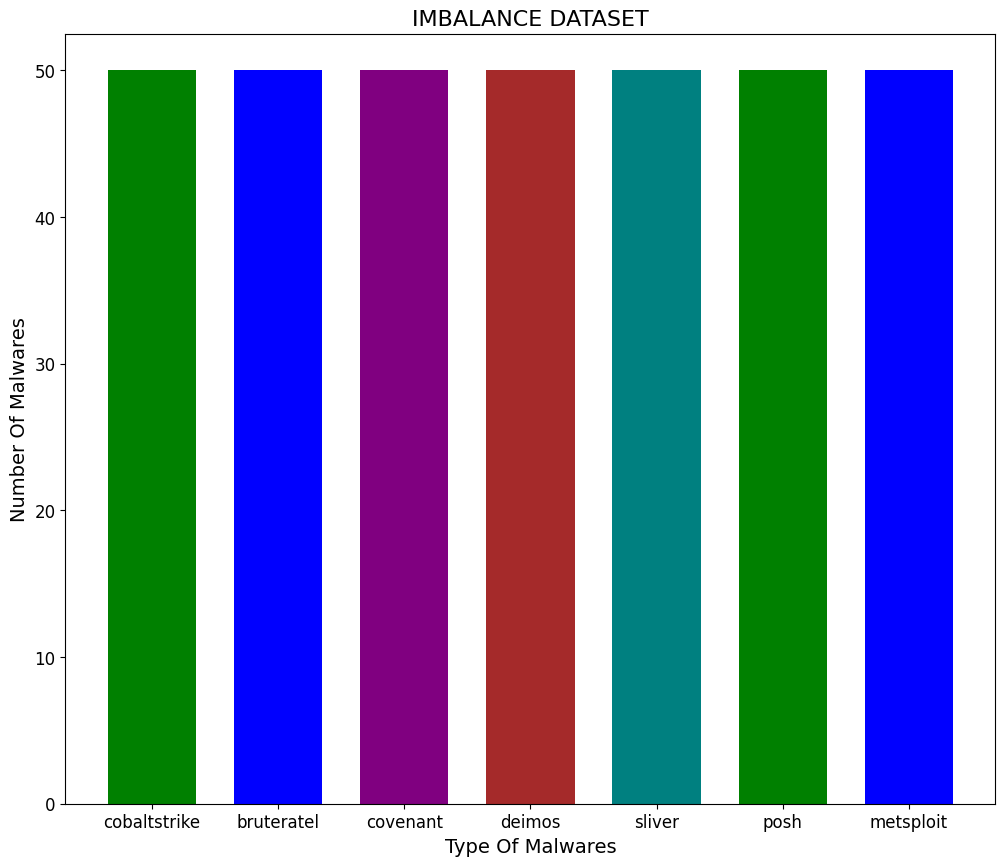

In [161]:
balanced_dataset_size = balanced_dataset["label"].value_counts().to_dict()
balanced_dataset_size = {k: v for k, v in sorted(list(balanced_dataset_size.items()))}

names = list(dataset_label.values())
values = list(balanced_dataset_size.values())
New_Colors = ["green","blue","purple","brown","teal"]
plt.figure(figsize=(12,10))
plt.bar(names,values,color=New_Colors,width=0.7)
plt.xticks(fontsize= 12 )
plt.yticks(fontsize= 12)
plt.title("IMBALANCE DATASET",fontsize=16)
plt.xlabel("Type Of Malwares", fontsize=14)
plt.ylabel("Number Of Malwares", fontsize=14)
plt.show()

#Classifier

In [162]:
X = balanced_dataset[["data_vector_mean", "data_vector_std", "node", "edge"]]
y = balanced_dataset["label"]

In [163]:
"""
classifiers = [
    RandomForestClassifier(n_estimators=100),
    XGBClassifier(),
    LGBMClassifier(),
    SVC(),
    CatBoostClassifier()
]
"""

rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5
)

xgb_classifier = XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    min_child_weight=1
)

lgbm_classifier = LGBMClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    min_child_samples=10
)

svc_classifier = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale'
)

catboost_classifier = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1
)

classifiers = [
    rf_classifier,
    xgb_classifier,
    lgbm_classifier,
    svc_classifier,
    catboost_classifier
]

In [164]:
results = {clf.__class__.__name__: {"accuracy": [], "precision": [], "recall": [], "f1": []} for clf in classifiers}

In [165]:
for clf in classifiers:
    for _ in tqdm(range(10)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="weighted")

        results[clf.__class__.__name__]["accuracy"].append(accuracy)
        results[clf.__class__.__name__]["precision"].append(precision)
        results[clf.__class__.__name__]["recall"].append(recall)
        results[clf.__class__.__name__]["f1"].append(f1)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -1.873589
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -1.873589
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -2.051271
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [W

 10%|█         | 1/10 [00:01<00:12,  1.33s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -1.971228
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -

 20%|██        | 2/10 [00:03<00:13,  1.63s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 153
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -2.051271
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -

 30%|███       | 3/10 [00:04<00:10,  1.49s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -2.051271
[LightGBM] [Info] Start training from score -1.828127
[LightGBM] [Info] Start training from score -1.971228
[LightGBM] [Info] Start training from score -

 40%|████      | 4/10 [00:05<00:08,  1.44s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.828127
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -

 50%|█████     | 5/10 [00:07<00:07,  1.44s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -

 60%|██████    | 6/10 [00:08<00:05,  1.29s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -1.873589
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -

 70%|███████   | 7/10 [00:09<00:03,  1.29s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -2.108429
[LightGBM] [Info] Start training from score -1.873589
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -

 80%|████████  | 8/10 [00:10<00:02,  1.27s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.971228
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -1.850600
[

 90%|█████████ | 9/10 [00:12<00:01,  1.31s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 1.8098828	total: 7ms	remaining: 1.39s
1:	learn: 1.6720244	total: 14.3ms	remaining: 1.42s
2:	learn: 1.5624431	total: 19.5ms	remaining: 1.28s
3:	learn: 1.5033856	total: 25.8ms	remaining: 1.27s
4:	learn: 1.4387964	total: 33.8ms	remaining: 1.32s
5:	learn: 1.3941263	total: 40.2ms	remaining: 1.3s
6:	learn: 1.3375201	total: 45.7ms	remaining: 1.26s
7:	learn: 1.2984716	total: 48.5ms	remaining: 1.16s
8:	learn: 1.2532757	total: 51.2ms	remaining: 1.09s
9:	learn: 1.2199827	total: 55.3ms	remaining: 1.05s
10:	learn: 1.1837626	total: 60.7ms	remaining: 1.04s
11:	learn: 1.1413006	total: 63.8ms	remaining: 1000ms
12:	learn: 1.1183524	total: 66.9ms	remaining: 962ms
13:	learn: 1.0811852	total: 69.8ms	remaining: 927ms
14:	learn: 1.0523458	total: 72.9ms	remaining: 899ms
15:	learn: 1.0300479	total: 76.1ms	remaining: 875ms
16:	learn: 1.0046202	total: 79.5ms	remaining: 855ms
17:	learn: 0.9880112	total: 82.6ms	remaining: 835ms
18:	learn: 0.9735995	total: 85.5ms	remaining: 815ms
19:	learn: 0.9544847	tota

 10%|█         | 1/10 [00:01<00:09,  1.05s/it]

180:	learn: 0.3238587	total: 776ms	remaining: 81.4ms
181:	learn: 0.3228198	total: 783ms	remaining: 77.4ms
182:	learn: 0.3219044	total: 789ms	remaining: 73.3ms
183:	learn: 0.3210741	total: 796ms	remaining: 69.2ms
184:	learn: 0.3200683	total: 805ms	remaining: 65.2ms
185:	learn: 0.3195397	total: 810ms	remaining: 61ms
186:	learn: 0.3186538	total: 817ms	remaining: 56.8ms
187:	learn: 0.3169733	total: 823ms	remaining: 52.5ms
188:	learn: 0.3154269	total: 831ms	remaining: 48.4ms
189:	learn: 0.3134023	total: 841ms	remaining: 44.3ms
190:	learn: 0.3125604	total: 848ms	remaining: 39.9ms
191:	learn: 0.3110237	total: 855ms	remaining: 35.6ms
192:	learn: 0.3097949	total: 861ms	remaining: 31.2ms
193:	learn: 0.3080412	total: 869ms	remaining: 26.9ms
194:	learn: 0.3073202	total: 875ms	remaining: 22.4ms
195:	learn: 0.3049657	total: 881ms	remaining: 18ms
196:	learn: 0.3040165	total: 885ms	remaining: 13.5ms
197:	learn: 0.3025427	total: 888ms	remaining: 8.97ms
198:	learn: 0.3005567	total: 893ms	remaining: 4.49

 20%|██        | 2/10 [00:02<00:10,  1.34s/it]

199:	learn: 0.2980653	total: 1.31s	remaining: 0us
0:	learn: 1.8463204	total: 12.8ms	remaining: 2.55s
1:	learn: 1.7439328	total: 20ms	remaining: 1.98s
2:	learn: 1.6570038	total: 26.4ms	remaining: 1.74s
3:	learn: 1.5872552	total: 33.2ms	remaining: 1.63s
4:	learn: 1.5192135	total: 40.2ms	remaining: 1.57s
5:	learn: 1.4801796	total: 46.1ms	remaining: 1.49s
6:	learn: 1.4195035	total: 53.7ms	remaining: 1.48s
7:	learn: 1.3670449	total: 61.4ms	remaining: 1.47s
8:	learn: 1.3244048	total: 68.5ms	remaining: 1.45s
9:	learn: 1.2944188	total: 73.7ms	remaining: 1.4s
10:	learn: 1.2604326	total: 81ms	remaining: 1.39s
11:	learn: 1.2342290	total: 86.8ms	remaining: 1.36s
12:	learn: 1.2088110	total: 94.5ms	remaining: 1.36s
13:	learn: 1.1780735	total: 100ms	remaining: 1.33s
14:	learn: 1.1528106	total: 108ms	remaining: 1.33s
15:	learn: 1.1208285	total: 113ms	remaining: 1.3s
16:	learn: 1.0846052	total: 123ms	remaining: 1.32s
17:	learn: 1.0619646	total: 127ms	remaining: 1.29s
18:	learn: 1.0401697	total: 141ms	r

 30%|███       | 3/10 [00:03<00:09,  1.35s/it]

167:	learn: 0.3184865	total: 1.06s	remaining: 203ms
168:	learn: 0.3173779	total: 1.07s	remaining: 196ms
169:	learn: 0.3157537	total: 1.08s	remaining: 190ms
170:	learn: 0.3137473	total: 1.08s	remaining: 184ms
171:	learn: 0.3113189	total: 1.09s	remaining: 177ms
172:	learn: 0.3100879	total: 1.09s	remaining: 170ms
173:	learn: 0.3091378	total: 1.09s	remaining: 163ms
174:	learn: 0.3081706	total: 1.1s	remaining: 157ms
175:	learn: 0.3068671	total: 1.1s	remaining: 150ms
176:	learn: 0.3053511	total: 1.1s	remaining: 143ms
177:	learn: 0.3042285	total: 1.11s	remaining: 137ms
178:	learn: 0.3032641	total: 1.11s	remaining: 130ms
179:	learn: 0.3025839	total: 1.11s	remaining: 124ms
180:	learn: 0.3005162	total: 1.12s	remaining: 117ms
181:	learn: 0.2997226	total: 1.12s	remaining: 111ms
182:	learn: 0.2987299	total: 1.12s	remaining: 104ms
183:	learn: 0.2980743	total: 1.13s	remaining: 97.9ms
184:	learn: 0.2973399	total: 1.13s	remaining: 91.6ms
185:	learn: 0.2958841	total: 1.13s	remaining: 85.3ms
186:	learn: 

 40%|████      | 4/10 [00:04<00:06,  1.14s/it]

176:	learn: 0.3256181	total: 607ms	remaining: 78.9ms
177:	learn: 0.3246543	total: 613ms	remaining: 75.8ms
178:	learn: 0.3237153	total: 620ms	remaining: 72.7ms
179:	learn: 0.3219016	total: 627ms	remaining: 69.6ms
180:	learn: 0.3211674	total: 630ms	remaining: 66.1ms
181:	learn: 0.3202168	total: 632ms	remaining: 62.5ms
182:	learn: 0.3189686	total: 635ms	remaining: 59ms
183:	learn: 0.3178497	total: 638ms	remaining: 55.5ms
184:	learn: 0.3164460	total: 641ms	remaining: 51.9ms
185:	learn: 0.3151864	total: 643ms	remaining: 48.4ms
186:	learn: 0.3141368	total: 646ms	remaining: 44.9ms
187:	learn: 0.3133912	total: 649ms	remaining: 41.4ms
188:	learn: 0.3119865	total: 652ms	remaining: 37.9ms
189:	learn: 0.3115226	total: 655ms	remaining: 34.5ms
190:	learn: 0.3106867	total: 659ms	remaining: 31ms
191:	learn: 0.3097937	total: 663ms	remaining: 27.6ms
192:	learn: 0.3086599	total: 666ms	remaining: 24.2ms
193:	learn: 0.3082531	total: 669ms	remaining: 20.7ms
194:	learn: 0.3072538	total: 676ms	remaining: 17.3

 50%|█████     | 5/10 [00:05<00:05,  1.03s/it]

173:	learn: 0.3048566	total: 618ms	remaining: 92.3ms
174:	learn: 0.3035269	total: 623ms	remaining: 88.9ms
175:	learn: 0.3023789	total: 630ms	remaining: 85.9ms
176:	learn: 0.3013072	total: 636ms	remaining: 82.6ms
177:	learn: 0.3000505	total: 639ms	remaining: 79ms
178:	learn: 0.2993408	total: 642ms	remaining: 75.4ms
179:	learn: 0.2986191	total: 646ms	remaining: 71.7ms
180:	learn: 0.2972102	total: 650ms	remaining: 68.2ms
181:	learn: 0.2963525	total: 653ms	remaining: 64.6ms
182:	learn: 0.2953814	total: 656ms	remaining: 60.9ms
183:	learn: 0.2946429	total: 660ms	remaining: 57.4ms
184:	learn: 0.2923978	total: 664ms	remaining: 53.9ms
185:	learn: 0.2913223	total: 668ms	remaining: 50.3ms
186:	learn: 0.2900010	total: 672ms	remaining: 46.7ms
187:	learn: 0.2882763	total: 676ms	remaining: 43.1ms
188:	learn: 0.2869012	total: 679ms	remaining: 39.5ms
189:	learn: 0.2842467	total: 682ms	remaining: 35.9ms
190:	learn: 0.2833053	total: 694ms	remaining: 32.7ms
191:	learn: 0.2821705	total: 699ms	remaining: 29

 60%|██████    | 6/10 [00:06<00:03,  1.04it/s]

167:	learn: 0.3123696	total: 617ms	remaining: 117ms
168:	learn: 0.3103596	total: 623ms	remaining: 114ms
169:	learn: 0.3097109	total: 628ms	remaining: 111ms
170:	learn: 0.3082780	total: 633ms	remaining: 107ms
171:	learn: 0.3067829	total: 636ms	remaining: 104ms
172:	learn: 0.3057870	total: 639ms	remaining: 99.8ms
173:	learn: 0.3042120	total: 642ms	remaining: 96ms
174:	learn: 0.3031951	total: 645ms	remaining: 92.2ms
175:	learn: 0.3025071	total: 648ms	remaining: 88.4ms
176:	learn: 0.2997335	total: 652ms	remaining: 84.7ms
177:	learn: 0.2986796	total: 655ms	remaining: 81ms
178:	learn: 0.2974085	total: 660ms	remaining: 77.4ms
179:	learn: 0.2958981	total: 663ms	remaining: 73.7ms
180:	learn: 0.2946167	total: 666ms	remaining: 69.9ms
181:	learn: 0.2935769	total: 669ms	remaining: 66.2ms
182:	learn: 0.2920408	total: 672ms	remaining: 62.5ms
183:	learn: 0.2907369	total: 675ms	remaining: 58.7ms
184:	learn: 0.2900645	total: 678ms	remaining: 55ms
185:	learn: 0.2885518	total: 682ms	remaining: 51.3ms
186:

 70%|███████   | 7/10 [00:07<00:02,  1.08it/s]

170:	learn: 0.3132414	total: 610ms	remaining: 103ms
171:	learn: 0.3111987	total: 622ms	remaining: 101ms
172:	learn: 0.3102426	total: 626ms	remaining: 97.7ms
173:	learn: 0.3093560	total: 632ms	remaining: 94.4ms
174:	learn: 0.3084006	total: 636ms	remaining: 90.9ms
175:	learn: 0.3071323	total: 640ms	remaining: 87.3ms
176:	learn: 0.3064804	total: 643ms	remaining: 83.6ms
177:	learn: 0.3050456	total: 646ms	remaining: 79.8ms
178:	learn: 0.3040735	total: 649ms	remaining: 76.1ms
179:	learn: 0.3023588	total: 651ms	remaining: 72.4ms
180:	learn: 0.3012906	total: 654ms	remaining: 68.7ms
181:	learn: 0.2998173	total: 657ms	remaining: 65ms
182:	learn: 0.2986653	total: 660ms	remaining: 61.3ms
183:	learn: 0.2976283	total: 664ms	remaining: 57.7ms
184:	learn: 0.2969406	total: 667ms	remaining: 54.1ms
185:	learn: 0.2960147	total: 671ms	remaining: 50.5ms
186:	learn: 0.2948690	total: 674ms	remaining: 46.8ms
187:	learn: 0.2938752	total: 677ms	remaining: 43.2ms
188:	learn: 0.2917268	total: 680ms	remaining: 39.6

 80%|████████  | 8/10 [00:08<00:01,  1.11it/s]

165:	learn: 0.3037960	total: 601ms	remaining: 123ms
166:	learn: 0.3026731	total: 606ms	remaining: 120ms
167:	learn: 0.3006901	total: 615ms	remaining: 117ms
168:	learn: 0.2996756	total: 620ms	remaining: 114ms
169:	learn: 0.2981820	total: 627ms	remaining: 111ms
170:	learn: 0.2974508	total: 630ms	remaining: 107ms
171:	learn: 0.2961595	total: 633ms	remaining: 103ms
172:	learn: 0.2952533	total: 636ms	remaining: 99.3ms
173:	learn: 0.2943167	total: 639ms	remaining: 95.5ms
174:	learn: 0.2930873	total: 642ms	remaining: 91.7ms
175:	learn: 0.2919700	total: 647ms	remaining: 88.2ms
176:	learn: 0.2905441	total: 651ms	remaining: 84.5ms
177:	learn: 0.2892781	total: 654ms	remaining: 80.9ms
178:	learn: 0.2881733	total: 658ms	remaining: 77.2ms
179:	learn: 0.2871717	total: 661ms	remaining: 73.4ms
180:	learn: 0.2863309	total: 664ms	remaining: 69.6ms
181:	learn: 0.2856428	total: 666ms	remaining: 65.9ms
182:	learn: 0.2845359	total: 669ms	remaining: 62.2ms
183:	learn: 0.2832594	total: 673ms	remaining: 58.5ms


 90%|█████████ | 9/10 [00:09<00:00,  1.12it/s]

0:	learn: 1.8088446	total: 7.72ms	remaining: 1.54s
1:	learn: 1.6751130	total: 14.3ms	remaining: 1.42s
2:	learn: 1.5709279	total: 18.7ms	remaining: 1.23s
3:	learn: 1.5088510	total: 23.3ms	remaining: 1.14s
4:	learn: 1.4461212	total: 28.4ms	remaining: 1.1s
5:	learn: 1.4118464	total: 32.3ms	remaining: 1.04s
6:	learn: 1.3560959	total: 37.1ms	remaining: 1.02s
7:	learn: 1.3082859	total: 41.1ms	remaining: 986ms
8:	learn: 1.2622932	total: 45.1ms	remaining: 957ms
9:	learn: 1.2312765	total: 48.1ms	remaining: 913ms
10:	learn: 1.1943666	total: 50.9ms	remaining: 875ms
11:	learn: 1.1653393	total: 53.6ms	remaining: 839ms
12:	learn: 1.1341611	total: 56.4ms	remaining: 812ms
13:	learn: 1.0977955	total: 63ms	remaining: 837ms
14:	learn: 1.0717442	total: 69.3ms	remaining: 854ms
15:	learn: 1.0489543	total: 74.4ms	remaining: 856ms
16:	learn: 1.0255061	total: 77.7ms	remaining: 837ms
17:	learn: 1.0063165	total: 80.8ms	remaining: 817ms
18:	learn: 0.9876594	total: 84.1ms	remaining: 801ms
19:	learn: 0.9679347	tota

100%|██████████| 10/10 [00:09<00:00,  1.00it/s]

187:	learn: 0.3093779	total: 767ms	remaining: 49ms
188:	learn: 0.3076302	total: 772ms	remaining: 45ms
189:	learn: 0.3067489	total: 777ms	remaining: 40.9ms
190:	learn: 0.3057177	total: 783ms	remaining: 36.9ms
191:	learn: 0.3047650	total: 792ms	remaining: 33ms
192:	learn: 0.3036904	total: 795ms	remaining: 28.8ms
193:	learn: 0.3018857	total: 798ms	remaining: 24.7ms
194:	learn: 0.2996430	total: 803ms	remaining: 20.6ms
195:	learn: 0.2992885	total: 809ms	remaining: 16.5ms
196:	learn: 0.2983547	total: 814ms	remaining: 12.4ms
197:	learn: 0.2968520	total: 818ms	remaining: 8.27ms
198:	learn: 0.2962678	total: 821ms	remaining: 4.13ms
199:	learn: 0.2955717	total: 824ms	remaining: 0us


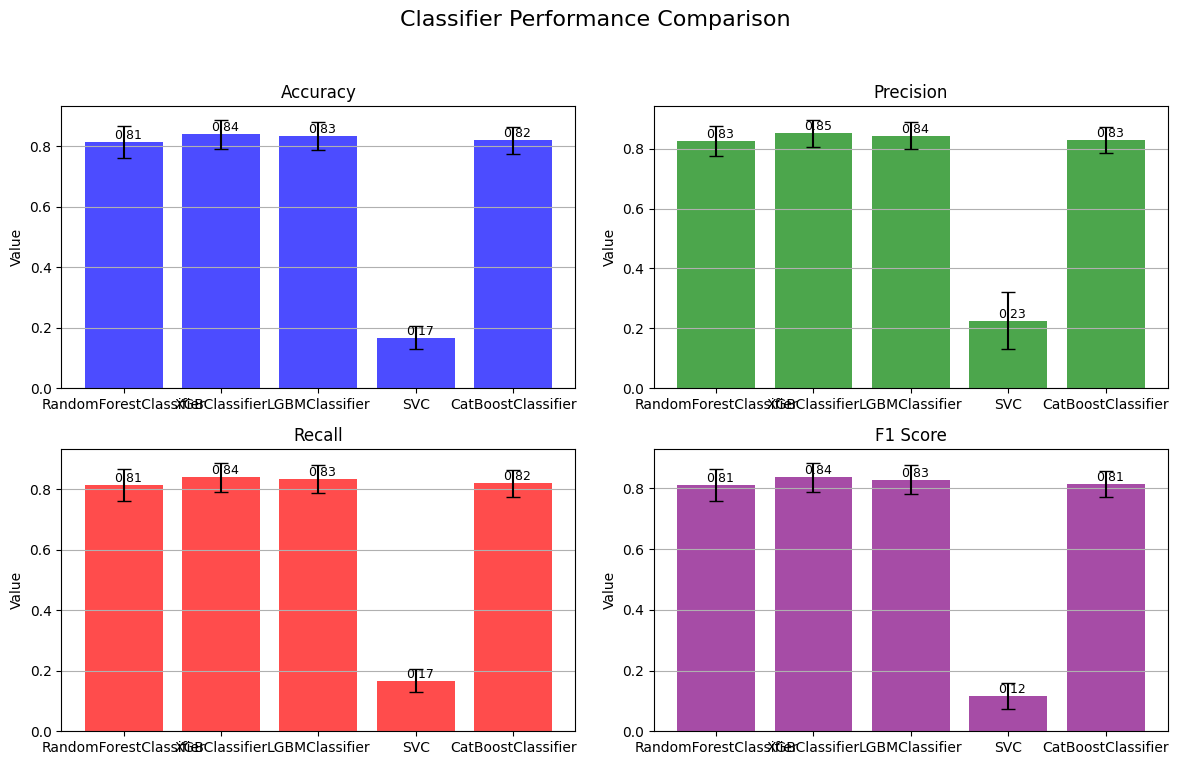

In [166]:
classifiers_names = [clf.__class__.__name__ for clf in classifiers]
accuracy_means = [np.mean(results[clf_name]["accuracy"]) for clf_name in classifiers_names]
precision_means = [np.mean(results[clf_name]["precision"]) for clf_name in classifiers_names]
recall_means = [np.mean(results[clf_name]["recall"]) for clf_name in classifiers_names]
f1_means = [np.mean(results[clf_name]["f1"]) for clf_name in classifiers_names]

accuracy_stds = [np.std(results[clf_name]["accuracy"]) for clf_name in classifiers_names]
precision_stds = [np.std(results[clf_name]["precision"]) for clf_name in classifiers_names]
recall_stds = [np.std(results[clf_name]["recall"]) for clf_name in classifiers_names]
f1_stds = [np.std(results[clf_name]["f1"]) for clf_name in classifiers_names]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Classifier Performance Comparison", fontsize=16)

# Accuracy
bars = axes[0, 0].bar(classifiers_names, accuracy_means, yerr=accuracy_stds, capsize=5, color="b", alpha=0.7)
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_ylabel("Value")
axes[0, 0].grid(axis="y")
for bar, acc in zip(bars, accuracy_means):
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2 - 0.1, acc + 0.01, f"{acc:.2f}", fontsize=9)

# Precision
bars = axes[0, 1].bar(classifiers_names, precision_means, yerr=precision_stds, capsize=5, color="g", alpha=0.7)
axes[0, 1].set_title("Precision")
axes[0, 1].set_ylabel("Value")
axes[0, 1].grid(axis="y")
for bar, prec in zip(bars, precision_means):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2 - 0.1, prec + 0.01, f"{prec:.2f}", fontsize=9)

# Recall
bars = axes[1, 0].bar(classifiers_names, recall_means, yerr=recall_stds, capsize=5, color="r", alpha=0.7)
axes[1, 0].set_title("Recall")
axes[1, 0].set_ylabel("Value")
axes[1, 0].grid(axis="y")
for bar, rec in zip(bars, recall_means):
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2 - 0.1, rec + 0.01, f"{rec:.2f}", fontsize=9)

# F1 Score
bars = axes[1, 1].bar(classifiers_names, f1_means, yerr=f1_stds, capsize=5, color="purple", alpha=0.7)
axes[1, 1].set_title("F1 Score")
axes[1, 1].set_ylabel("Value")
axes[1, 1].grid(axis="y")
for bar, f1 in zip(bars, f1_means):
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2 - 0.1, f1 + 0.01, f"{f1:.2f}", fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()